In [1]:
import numpy as np
import matplotlib.pyplot as plt

def comparar_LVE_spinode(
    x10=1.0, x20=1.0,
    T=10.0,
    N_big=200,      # pasos "gruesos"
    refine=10,      # subpasos finos por cada paso grueso
    k1=0.4, k2=0.5
):
    """
    LVE competitivo:
        g1_1 = x1 (1 - x1 - k1 x2)
        g1_2 = x2 (1 - x2 - k2 x1)
        g2_1 = x1 (x2 - x2_eq)
        g2_2 = x2 (x1 - x1_eq)
    Compara trayectoria con dt grande vs referencia con dt pequeño.
    """

    # Equilibrio de coexistencia
    den   = 1.0 - k1 * k2
    x1_eq = (1.0 - k1) / den
    x2_eq = (1.0 - k2) / den

    # Malla fina y gruesa
    N_small  = N_big * refine
    dt_small = T / N_small
    dt_big   = T / N_big

    # Brownianos independientes en malla fina
    Z1 = np.random.randn(N_small)
    Z2 = np.random.randn(N_small)
    dW1_small = np.sqrt(dt_small) * Z1
    dW2_small = np.sqrt(dt_small) * Z2

    # Trayectoria de referencia (dt pequeño)
    x1_ref = np.zeros(N_small + 1)
    x2_ref = np.zeros(N_small + 1)
    x1_ref[0], x2_ref[0] = x10, x20

    for k in range(N_small):
        x1, x2 = x1_ref[k], x2_ref[k]

        # Drift g1
        g1_1 = x1 * (1.0 - x1 - k1 * x2)
        g1_2 = x2 * (1.0 - x2 - k2 * x1)

        # Difusión g2
        g2_1 = x1 * (x2 - x2_eq)
        g2_2 = x2 * (x1 - x1_eq)

        # Truncación para evitar sqrt de negativo
        g2_1_pos = max(g2_1, 0.0)
        g2_2_pos = max(g2_2, 0.0)

        x1_ref[k+1] = x1 + g1_1 * dt_small + np.sqrt(2.0 * g2_1_pos * dt_small) * dW1_small[k]
        x2_ref[k+1] = x2 + g1_2 * dt_small + np.sqrt(2.0 * g2_2_pos * dt_small) * dW2_small[k]

        # Opcional: evitar valores negativos
        x1_ref[k+1] = max(x1_ref[k+1], 0.0)
        x2_ref[k+1] = max(x2_ref[k+1], 0.0)

    # Índices y tiempos gruesos
    idx_big   = np.arange(0, N_small + 1, refine)
    t_big     = idx_big * dt_small
    x1_ref_big = x1_ref[idx_big]
    x2_ref_big = x2_ref[idx_big]

    # Trayectoria con dt grande
    x1_big = np.zeros(N_big + 1)
    x2_big = np.zeros(N_big + 1)
    x1_big[0], x2_big[0] = x10, x20

    for j in range(N_big):
        # Agregar refine incrementos pequeños -> un incremento grande
        dW1 = dW1_small[j*refine:(j+1)*refine].sum()
        dW2 = dW2_small[j*refine:(j+1)*refine].sum()

        x1, x2 = x1_big[j], x2_big[j]

        g1_1 = x1 * (1.0 - x1 - k1 * x2)
        g1_2 = x2 * (1.0 - x2 - k2 * x1)

        g2_1 = x1 * (x2 - x2_eq)
        g2_2 = x2 * (x1 - x1_eq)

        g2_1_pos = max(g2_1, 0.0)
        g2_2_pos = max(g2_2, 0.0)

        x1_big[j+1] = x1 + g1_1 * dt_big + np.sqrt(2.0 * g2_1_pos * dt_big) * dW1
        x2_big[j+1] = x2 + g1_2 * dt_big + np.sqrt(2.0 * g2_2_pos * dt_big) * dW2

        x1_big[j+1] = max(x1_big[j+1], 0.0)
        x2_big[j+1] = max(x2_big[j+1], 0.0)

    # Gráficos
    plt.figure(figsize=(8, 5))
    plt.plot(t_big, x1_big, label="x1 esquema (dt grande)")
    plt.plot(t_big, x1_ref_big, "--", label="x1 referencia (dt pequeño)")
    plt.xlabel("Tiempo")
    plt.ylabel("x1(t)")
    plt.title("Comparación x1(t) LVE")
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(8, 5))
    plt.plot(t_big, x2_big, label="x2 esquema (dt grande)")
    plt.plot(t_big, x2_ref_big, "--", label="x2 referencia (dt pequeño)")
    plt.xlabel("Tiempo")
    plt.ylabel("x2(t)")
    plt.title("Comparación x2(t) LVE")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Errores
    err1 = x1_big - x1_ref_big
    err2 = x2_big - x2_ref_big
    print("x1 - Error máx:", np.max(np.abs(err1)), " RMSE:", np.sqrt(np.mean(err1**2)))
    print("x2 - Error máx:", np.max(np.abs(err2)), " RMSE:", np.sqrt(np.mean(err2**2)))

    return t_big, x1_big, x1_ref_big, x2_big, x2_ref_big


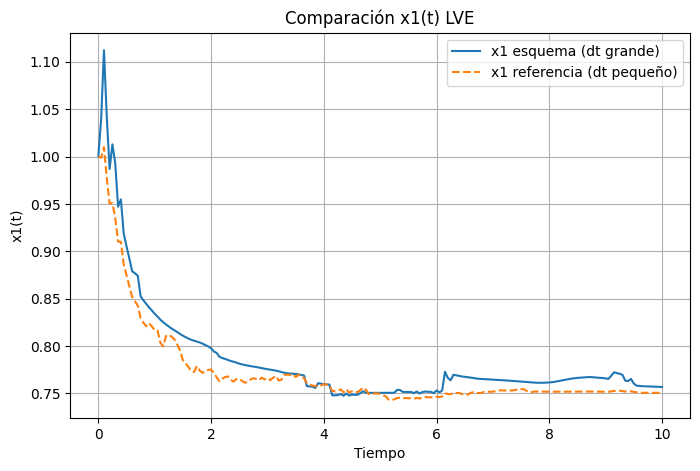

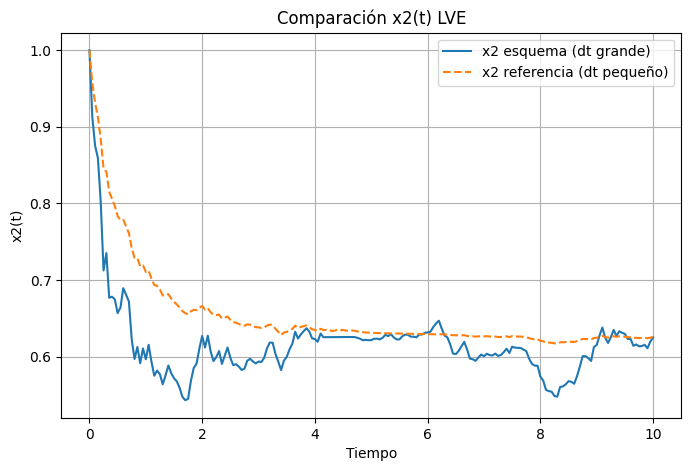

x1 - Error máx: 0.10230429997328527  RMSE: 0.018462040570245378
x2 - Error máx: 0.13838054108308895  RMSE: 0.05300888536117329


In [2]:
t, x1_esq, x1_ref, x2_esq, x2_ref = comparar_LVE_spinode()